# [$\alpha$/Fe] Bimodality Test

In [5]:
from tqdm import tqdm
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/scripts')
from apogee_tools import import_apogee, apogee_region, apogee_mdf
from multizone_stars import MultizoneStars
from utils import get_bin_centers, sample_dataframe

In [3]:
apogee_data = import_apogee()
apogee_subset = apogee_region(apogee_data, galr_lim=(7, 9), absz_lim=(0, 2))

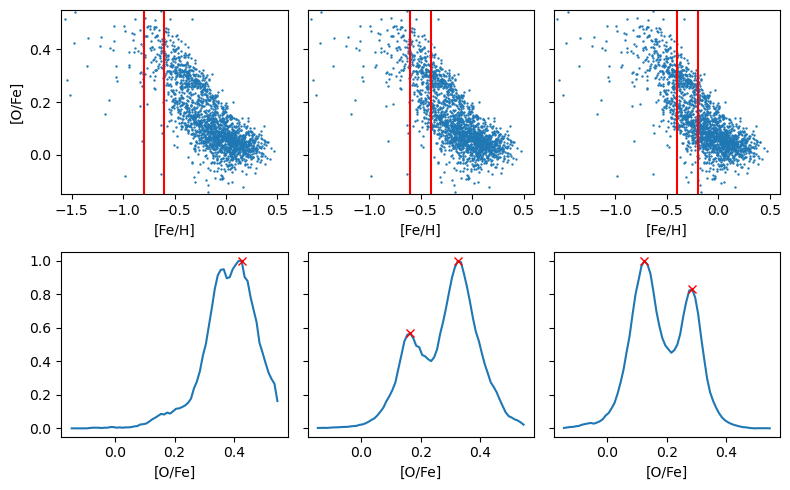

In [68]:
feh_slices = [-0.7, -0.5, -0.3]
slice_width = 0.2

apogee_sample = sample_dataframe(apogee_subset, 2000)

fig, axs = plt.subplots(2, 3, figsize=(8, 5), sharex='row', sharey='row', tight_layout=True)

for j, feh_slice in enumerate(feh_slices):
    feh_min = feh_slice - slice_width/2
    feh_max = feh_slice + slice_width/2
    axs[0,j].scatter(apogee_sample['FE_H'], apogee_sample['O_FE'], s=0.5)
    axs[0,j].axvline(feh_min, c='r')
    axs[0,j].axvline(feh_max, c='r')
    apogee_slice = apogee_subset[(apogee_subset['FE_H'] > feh_min) & (apogee_subset['FE_H'] < feh_max)]
    # Plot [O/Fe] MDFs
    mdf, bin_edges = apogee_mdf(apogee_slice, 'O_FE', bins=np.arange(-0.15, 0.56, 0.01), smoothing=0.05)
    mdf /= mdf.max()
    peaks, _ = find_peaks(mdf, prominence=0.1)
    bin_centers = get_bin_centers(bin_edges)
    axs[1,j].plot(bin_centers, mdf)
    axs[1,j].plot(bin_centers[peaks], mdf[peaks], 'rx')

axs[0,0].set_xlim((-1.6, 0.6))
axs[0,0].set_ylim((-0.15, 0.55))
for ax in axs[0]:
    ax.set_xlabel('[Fe/H]')
axs[0,0].set_ylabel('[O/Fe]')
for ax in axs[1]:
    ax.set_xlabel('[O/Fe]')
plt.show()

In [80]:
def plot_vice_slices(mzs, feh_slices=(-0.7, -0.5, -0.3), slice_width=0.2, prominence=0.1, smoothing=0.05):
    vice_subset = mzs.region(galr_lim=(7, 9)).model_uncertainty(apogee_data)
    vice_sample = vice_subset.sample(2000)

    fig, axs = plt.subplots(2, 3, figsize=(8, 5), sharex='row', sharey='row', tight_layout=True)

    for j, feh_slice in enumerate(feh_slices):
        feh_min = feh_slice - slice_width/2
        feh_max = feh_slice + slice_width/2
        axs[0,j].scatter(vice_sample['[fe/h]'], vice_sample['[o/fe]'], s=0.5)
        axs[0,j].axvline(feh_min, c='r')
        axs[0,j].axvline(feh_max, c='r')
        vice_slice = vice_subset.filter({'[fe/h]': (feh_min, feh_max)})
        # Plot [O/Fe] MDFs
        mdf, bin_edges = vice_slice.mdf('[o/fe]', bins=np.arange(-0.15, 0.56, 0.01), smoothing=smoothing)
        mdf /= mdf.max()
        peaks, _ = find_peaks(mdf, prominence=prominence)
        bin_centers = get_bin_centers(bin_edges)
        axs[1,j].plot(bin_centers, mdf)
        axs[1,j].plot(bin_centers[peaks], mdf[peaks], 'rx')

    axs[0,0].set_xlim((-1.6, 0.6))
    axs[0,0].set_ylim((-0.15, 0.55))
    for ax in axs[0]:
        ax.set_xlabel('[Fe/H]')
    axs[0,0].set_ylabel('[O/Fe]')
    for ax in axs[1]:
        ax.set_xlabel('[O/Fe]')
    plt.show()

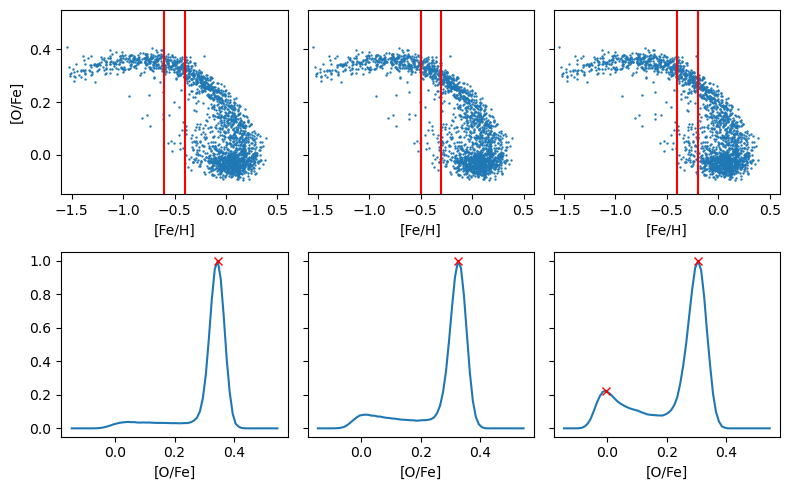

In [91]:
earlyburst_mzs = MultizoneStars.from_output('gaussian/earlyburst/exponential_timescale30')
plot_vice_slices(earlyburst_mzs, feh_slices=(-0.5, -0.4, -0.3), smoothing=0.05, prominence=0.1)

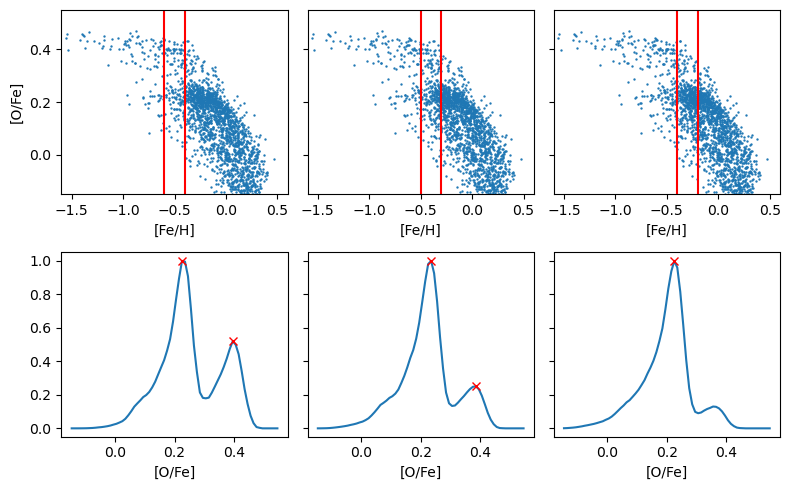

In [92]:
twoinfall_mzs = MultizoneStars.from_output('gaussian/twoinfall/exponential_timescale30')
plot_vice_slices(twoinfall_mzs, feh_slices=(-0.5, -0.4, -0.3), smoothing=0.05, prominence=0.1)

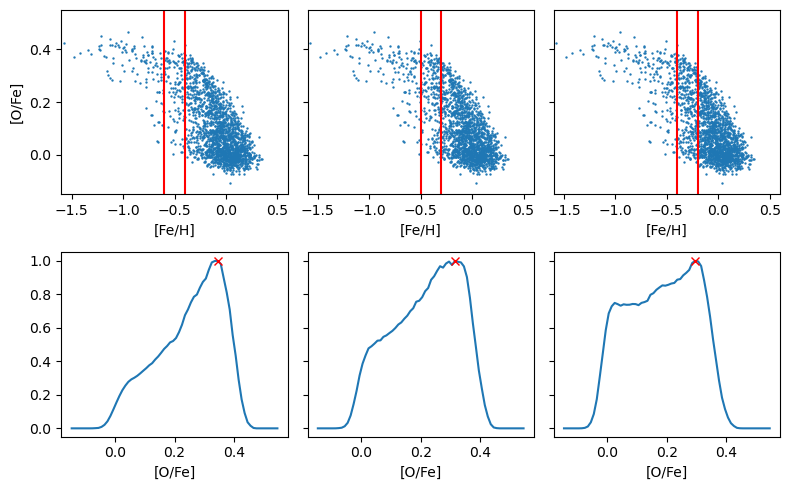

In [93]:
insideout_mzs = MultizoneStars.from_output('gaussian/insideout/exponential_timescale30')
plot_vice_slices(insideout_mzs, feh_slices=(-0.5, -0.4, -0.3), prominence=0.1, smoothing=0.05)

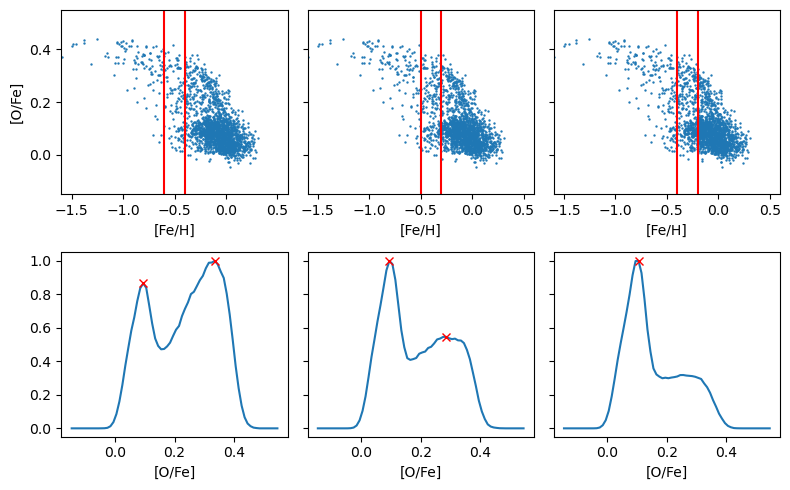

In [94]:
lateburst_mzs = MultizoneStars.from_output('gaussian/lateburst/exponential_timescale30')
plot_vice_slices(lateburst_mzs, feh_slices=(-0.5, -0.4, -0.3), smoothing=0.05, prominence=0.1)

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [11:21<00:00, 21.30s/it]


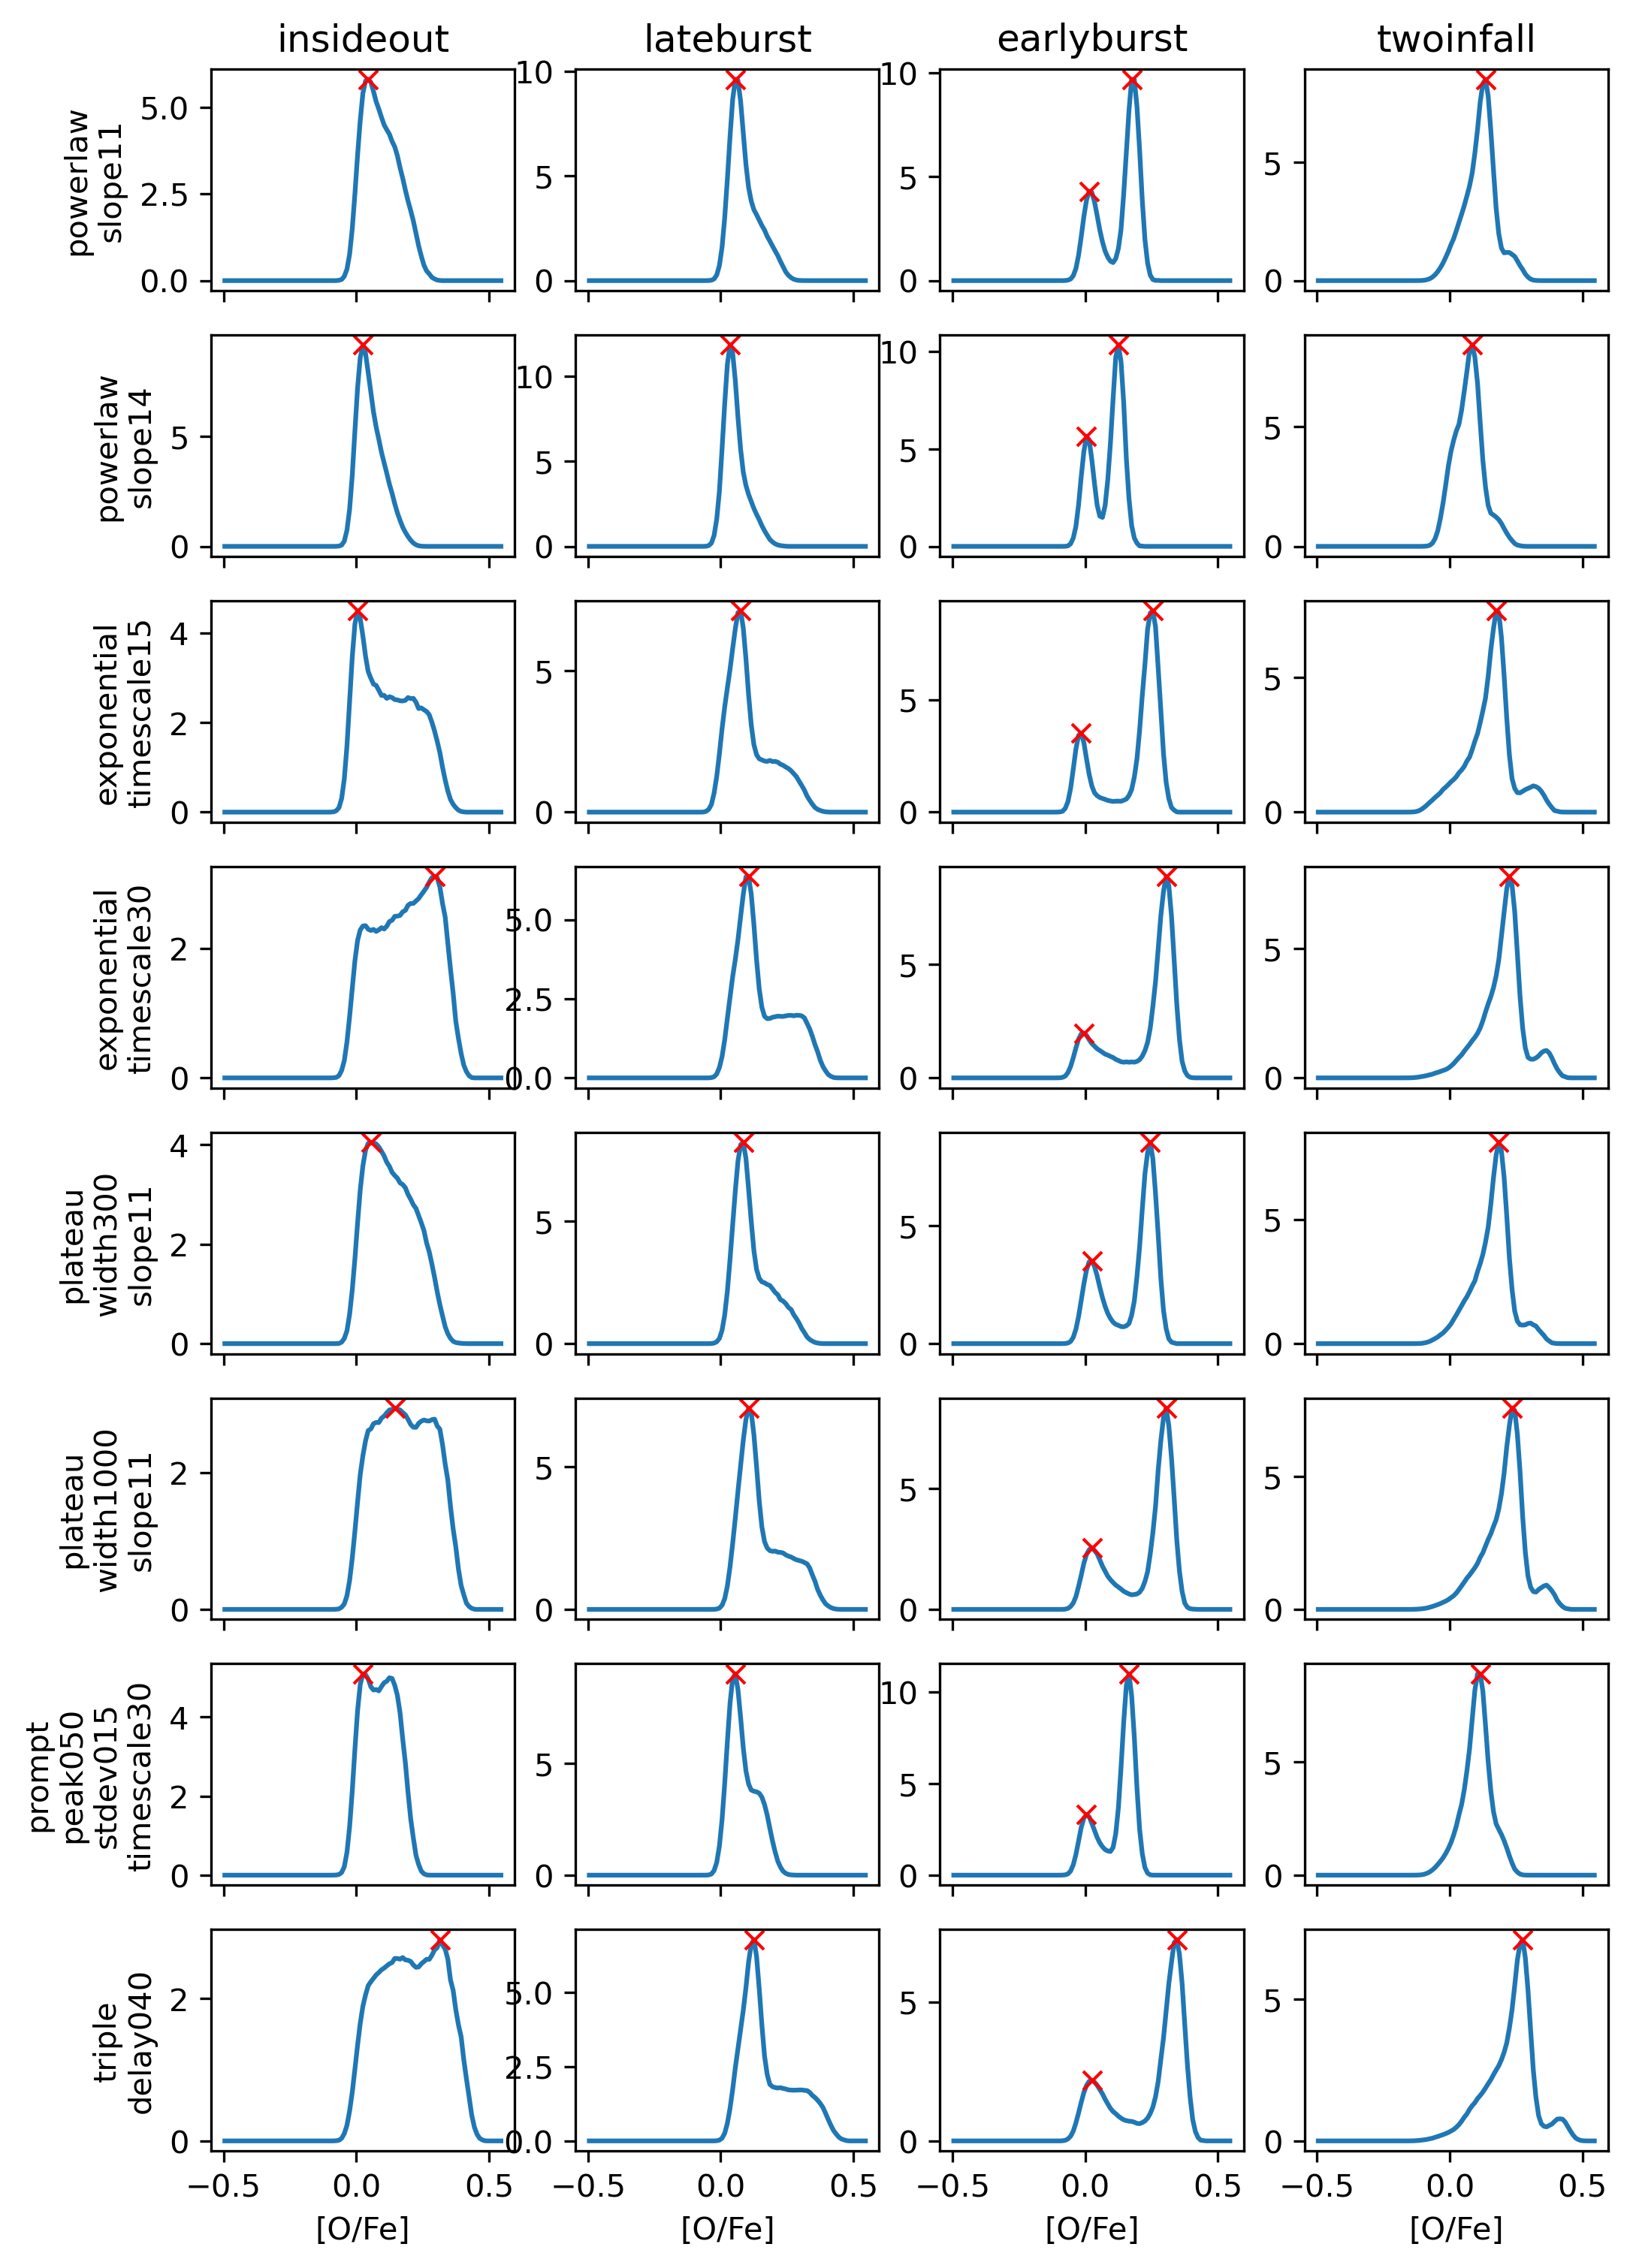

In [132]:
sfh_list = ['insideout', 'lateburst', 'earlyburst', 'twoinfall']
dtd_list = ['powerlaw_slope11', 
            'powerlaw_slope14', 
            'exponential_timescale15',
            'exponential_timescale30',
            'plateau_width300_slope11',
            'plateau_width1000_slope11',
            'prompt_peak050_stdev015_timescale30',
            'triple_delay040']
migration = 'gaussian'

fig, axs = plt.subplots(len(dtd_list), len(sfh_list), dpi=300, sharex=True, figsize=(8, 12))

with tqdm(total=len(sfh_list) * len(dtd_list)) as t:
    for i, dtd in enumerate(dtd_list):
        for j, sfh in enumerate(sfh_list):
            mzs = MultizoneStars.from_output('/'.join([migration, sfh, dtd]))
            vice_subset = mzs.region(galr_lim=(7, 9)).filter({'[fe/h]': (-0.4, -0.2)}).model_uncertainty(apogee_data)
            mdf, bin_edges = vice_subset.mdf('[o/fe]', bins=np.arange(-0.5, 0.56, 0.01), smoothing=0.05)
            peaks, _ = find_peaks(mdf/mdf.max(), prominence=0.1)
            bin_centers = get_bin_centers(bin_edges)
            axs[i,j].plot(bin_centers, mdf)
            axs[i,j].plot(bin_centers[peaks], mdf[peaks], 'rx')
            axs[-1,j].set_xlabel('[O/Fe]')
            axs[0,j].set_title(sfh)
            t.update()
        axs[i,0].set_ylabel(dtd.replace('_', '\n'))

plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [07:49<00:00, 14.66s/it]


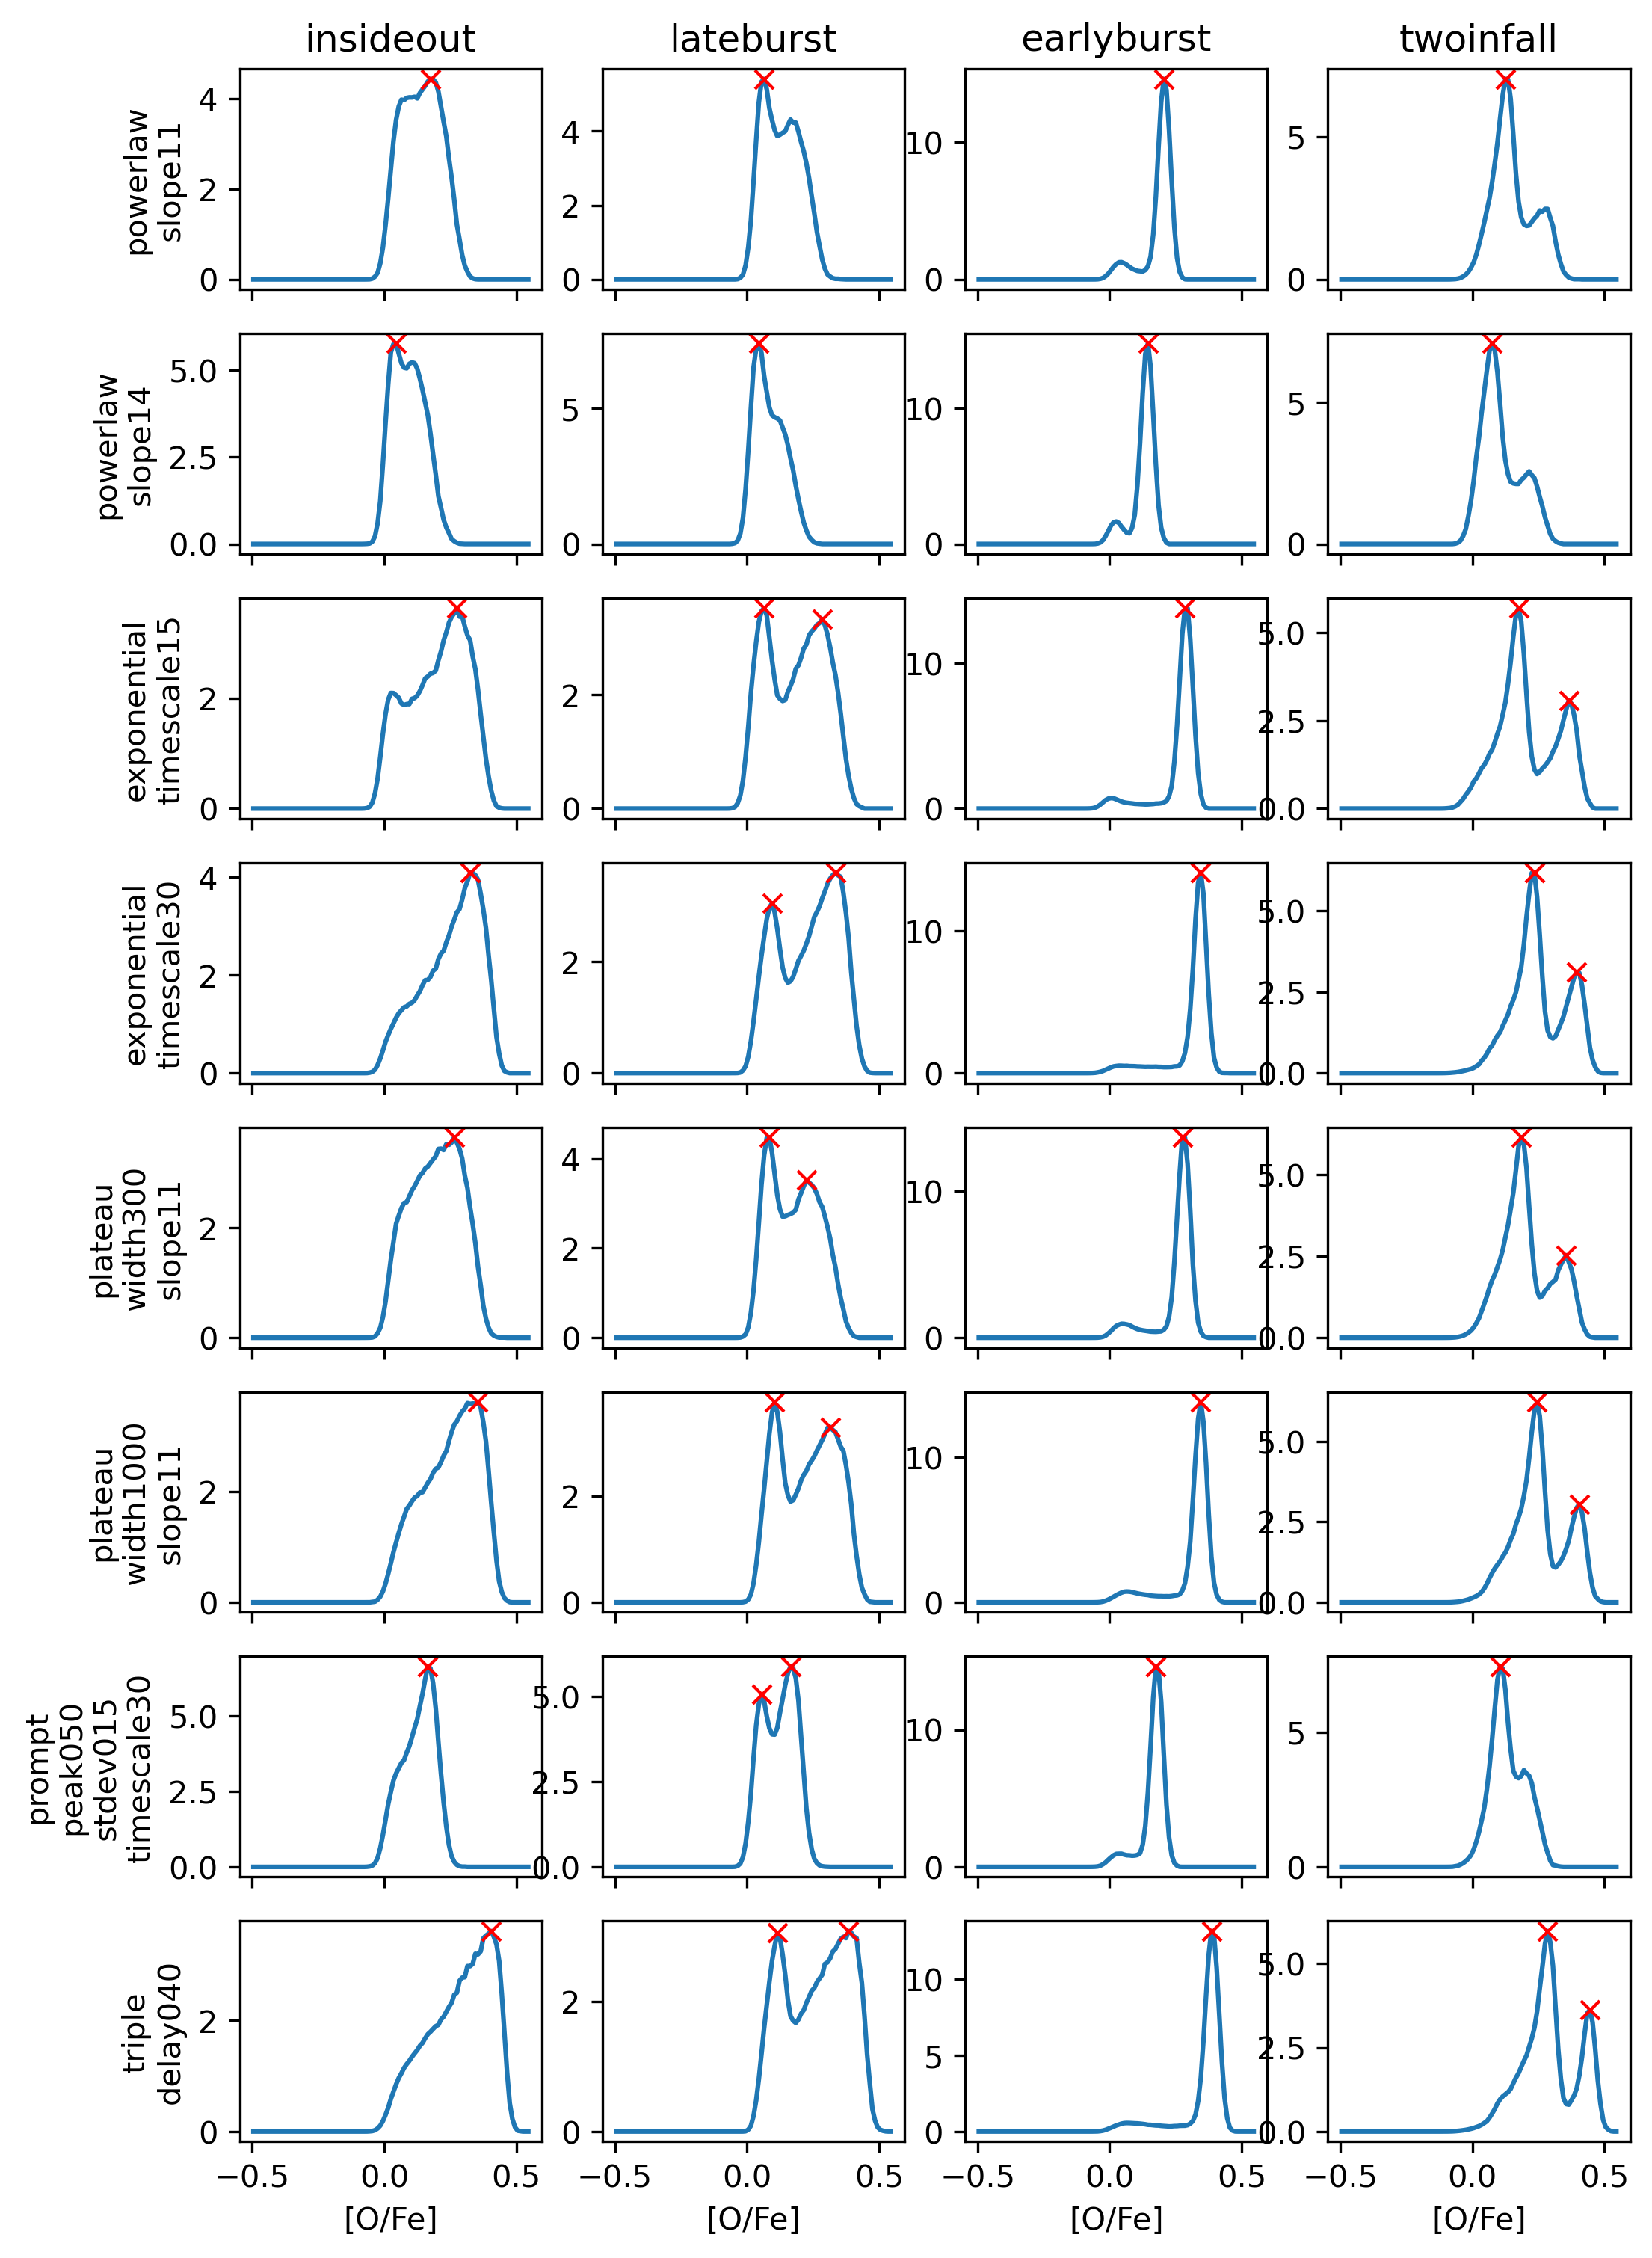

In [76]:
sfh_list = ['insideout', 'lateburst', 'earlyburst', 'twoinfall']
dtd_list = ['powerlaw_slope11', 
            'powerlaw_slope14', 
            'exponential_timescale15',
            'exponential_timescale30',
            'plateau_width300_slope11',
            'plateau_width1000_slope11',
            'prompt_peak050_stdev015_timescale30',
            'triple_delay040']
migration = 'gaussian'

fig, axs = plt.subplots(len(dtd_list), len(sfh_list), dpi=300, sharex=True, figsize=(8, 12))

with tqdm(total=len(sfh_list) * len(dtd_list)) as t:
    for i, dtd in enumerate(dtd_list):
        for j, sfh in enumerate(sfh_list):
            mzs = MultizoneStars.from_output('/'.join([migration, sfh, dtd]))
            vice_subset = mzs.region(galr_lim=(7, 9)).filter({'[fe/h]': (-0.6, -0.4)}).model_uncertainty(apogee_data)
            mdf, bin_edges = vice_subset.mdf('[o/fe]', bins=np.arange(-0.5, 0.56, 0.01), smoothing=0.05)
            peaks, _ = find_peaks(mdf/mdf.max(), prominence=0.1)
            bin_centers = get_bin_centers(bin_edges)
            axs[i,j].plot(bin_centers, mdf)
            axs[i,j].plot(bin_centers[peaks], mdf[peaks], 'rx')
            axs[-1,j].set_xlabel('[O/Fe]')
            axs[0,j].set_title(sfh)
            t.update()
        axs[i,0].set_ylabel(dtd.replace('_', '\n'))

plt.show()

In [75]:
class NormalGaussian:
    def __init__(self, center=1, stdev=1):
        self.center = center
        self.stdev = stdev
        self.norm = 1 / (stdev * np.sqrt(2 * np.pi))

    def __call__(self, x):
        return self.norm * np.exp(-(x-self.center)**2 / (2*self.stdev**2))
    
def one_gaussian(x, center, stdev):
    ng = NormalGaussian(center, stdev)
    return ng(x)

def two_gaussian(x, center1, stdev1, coeff1, center2, stdev2):
    ng1 = NormalGaussian(center1, stdev1)
    ng2 = NormalGaussian(center2, stdev2)
    return coeff1 * ng1(x) + (1 - coeff1) * ng2(x)

In [76]:
mzs = MultizoneStars.from_output('gaussian/insideout/powerlaw_slope11')

[0.03505216 0.03142477 0.32238866 0.12127812 0.06466366]
1.3334531450331997


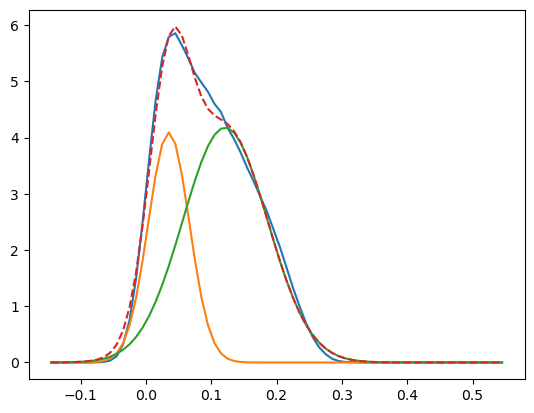

In [82]:
vice_subset = mzs.region(galr_lim=(7, 9)).filter({'[fe/h]': (-0.4, -0.2)}).model_uncertainty()
mdf, bin_edges = vice_subset.mdf('[o/fe]', bins=np.arange(-0.15, 0.56, 0.01), smoothing=0.05)
bin_centers = get_bin_centers(bin_edges)

popt, pcov = curve_fit(two_gaussian, bin_centers, mdf, 
                       p0=(0.1, 0.05, 0.5, 0.3, 0.05),
                       bounds=([-np.inf, 0, 0, -np.inf, 0],
                               [np.inf, np.inf, 1, np.inf, np.inf]))
print(popt)
print(abs(popt[3] - popt[0]) / max(popt[1], popt[4]))

plt.plot(bin_centers, mdf)
plt.plot(bin_centers, popt[2] * one_gaussian(bin_centers, *popt[:2]))
plt.plot(bin_centers, (1 - popt[2]) * one_gaussian(bin_centers, *popt[3:]))
plt.plot(bin_centers, two_gaussian(bin_centers, *popt), '--')
plt.show()